In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

from collections import Counter

In [2]:
def calc_accuracy(y_true, y_pred, metric='mae'):
    if metric == 'mae':
        acc = mean_absolute_error(y_true, y_pred)
    elif metric == 'r2':
        acc = r2_score(y_true, y_pred)
    elif metric == 'rmse':
        acc = root_mean_squared_error(y_true, y_pred)

    return acc

def plot_model_boxplots(df: pd.DataFrame, metric_name='R²', higher_is_better=True):
    """
    Plots boxplots sorted by median performance for each model using seaborn and
    annotates each box with its median value.

    Parameters:
        df (pd.DataFrame): Rows = datasets, Columns = models, Values = performance metric.
        metric_name (str): Name of the metric to label the y-axis (e.g., 'R²', 'RMSE').
        higher_is_better (bool): Used in the title to indicate desired metric direction.
    """
    # Melt the DataFrame into long format for seaborn
    melted = df.reset_index(drop=True).melt(var_name='Model', value_name=metric_name)

    # Compute median performance for sorting and annotation
    medians = melted.groupby('Model')[metric_name].median().sort_values(ascending=not higher_is_better)
    model_order = medians.index.tolist()

    # Set style
    sns.set(style="whitegrid")

    # Create the boxplot with sorted model order
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        data=melted,
        x='Model',
        y=metric_name,
        order=model_order,
        showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )

    # Annotate each box with the median value
    for i, model in enumerate(model_order):
        median_val = medians[model]
        ax.text(i, median_val, f'{median_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

    # Annotate title
    direction = "Higher is better" if higher_is_better else "Lower is better"
    plt.title(f'Model Performance ({metric_name}) - {direction}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def compute_cumulative_top_k(df: pd.DataFrame, k: int = None, higher_is_better: bool = True) -> pd.DataFrame:
    """
    Compute how often each model was in the Top-k positions, cumulatively, with options for k and higher_is_better.
    
    Parameters:
        df (pd.DataFrame): DataFrame where each column is a model, 
                           each row is a dataset, and values are regression metrics (e.g., R²).
        k (int, optional): The number of top positions to count (default is None, which counts up to all available models).
        higher_is_better (bool, optional): If True, assumes higher values are better (default is True).
    
    Returns:
        pd.DataFrame: A DataFrame showing cumulative Top-k counts per model.
    """
    # Rank models in descending or ascending order based on 'higher_is_better' parameter
    ranks = df.rank(axis=1, method='min', ascending=not higher_is_better)
    
    # Set k to the number of models if None
    if k is None:
        k = len(df.columns)
    
    # Prepare result container
    top_k_counts = pd.DataFrame(index=df.columns)
    
    # Calculate cumulative counts for Top-1, Top-2, ..., Top-k
    for i in range(1, k + 1):
        in_top_k = (ranks <= i).sum()
        top_k_counts[f'Top-{i}'] = in_top_k
    
    # Return the DataFrame with cumulative top-k counts per model
    return top_k_counts

def compare_two_models(df: pd.DataFrame, model_1: str, model_2: str, higher_is_better=True) -> dict:
    """
    Compares two models across datasets and counts how often each is better.
    
    Parameters:
        df (pd.DataFrame): Rows = datasets, Columns = models.
        model_1 (str): First model name.
        model_2 (str): Second model name.
        higher_is_better (bool): Whether higher values are better (e.g., RÂ²) or worse (e.g., RMSE).
        
    Returns:
        dict: Counts of how often model_1 wins, model_2 wins, and ties.
    """
    assert model_1 in df.columns and model_2 in df.columns, "Both model names must be in the DataFrame."

    m1_vals = df[model_1]
    m2_vals = df[model_2]
    
    if higher_is_better:
        m1_better = (m1_vals > m2_vals).sum()
        m2_better = (m2_vals > m1_vals).sum()
    else:
        m1_better = (m1_vals < m2_vals).sum()
        m2_better = (m2_vals < m1_vals).sum()

    ties = (m1_vals == m2_vals).sum()

    return {
        f"{model_1} better": m1_better.item(),
        f"{model_2} better": m2_better.item(),
        "Ties": ties.item()
    }

### Set up

In [3]:
bench_result = Path("benchmark_model_consensus")
os.listdir(bench_result)

['acf', 'chembl', 'molnet']

In [4]:
bench_folder = os.path.join(bench_result, "chembl")
bench_folder

'benchmark_model_consensus/chembl'

In [5]:
metric = "r2"

### Models performance summury

In [6]:
result_df = []
for bench_dataset in os.listdir(bench_folder):

    # read predictions
    train_df = pd.read_csv(os.path.join(bench_folder, bench_dataset, "train.csv"))
    test_df = pd.read_csv(os.path.join(bench_folder, bench_dataset, "test.csv"))
    
    # calc accuracy metric for each consensus/stacking method for test set predictions
    acc_test = test_df.drop(columns='Y_TRUE').apply(lambda col: calc_accuracy(test_df['Y_TRUE'], col, metric=metric))

    # get rid of scientific nitation like -1.422665e+09 for stable mean calcualtion
    # ATTENTION! if for example r2 = -12435t5.2 it will be converted to 0 for the method -> it is nit completely correct
    if metric == "r2": # conditions for TODO other metrics (ame, rmse)
        acc_test = acc_test.where(acc_test > 10 ** -3, other=0)
    result_df.append(acc_test)
#
result_df = pd.DataFrame(result_df)
result_df

,Best,All,Random,Systematic,Genetic,Stack_test_LinearRegression(),Stack_test_RandomForestRegressor(),Stack_test_MLPRegressor(),Stack_test_Ridge(),Stack_test_SVR(),Stack_test_KNeighborsRegressor()
0,0.763605,0.714509,0.710536,0.763605,0.764627,0.533973,0.722856,0.576706,0.545174,0.685033,0.700924
1,0.550658,0.536480,0.505066,0.550658,0.606743,0.379055,0.459531,0.461114,0.400658,0.450278,0.468500
2,0.644677,0.556447,0.456540,0.644677,0.676694,0.610401,0.671078,0.572872,0.611922,0.605458,0.571219
3,0.633182,0.526289,0.000000,0.633182,0.655807,0.492704,0.545665,0.487769,0.493310,0.000000,0.629454
4,0.631435,0.591143,0.373626,0.631435,0.664497,0.625814,0.667999,0.603782,0.628695,0.625799,0.542315
...,...,...,...,...,...,...,...,...,...,...,...
195,0.597586,0.000000,0.357776,0.597586,0.608298,0.359263,0.454650,0.000000,0.365944,0.402007,0.334100
196,0.658218,0.565920,0.000000,0.658218,0.649549,0.508111,0.498273,0.558317,0.533948,0.610691,0.345857
197,0.771578,0.000000,0.000000,0.771578,0.787047,0.000000,0.750838,0.000000,0.000000,0.771617,0.694160
198,0.720244,0.690762,0.585166,0.720244,0.726497,0.624581,0.680495,0.674405,0.636969,0.688062,0.659813


### 1. Mean accuracy

In [7]:
result_df.mean().to_frame().sort_values(by=0, ascending=False).round(2)

,0
Genetic,0.67
Systematic,0.65
Best,0.65
Stack_test_RandomForestRegressor(),0.63
Stack_test_KNeighborsRegressor(),0.52
Stack_test_Ridge(),0.50
Stack_test_LinearRegression(),0.49
Random,0.47
Stack_test_SVR(),0.40
All,0.37


### 2. Accuracy boxplot

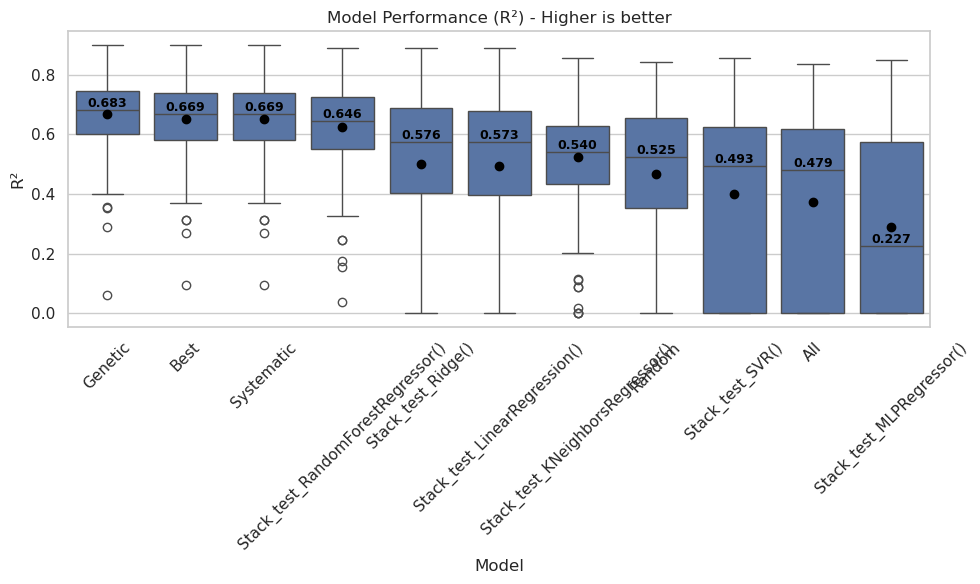

In [8]:
plot_model_boxplots(result_df, metric_name='R²', higher_is_better=True)

### 3. Top-N statistics

In [9]:
pair_df = compute_cumulative_top_k(result_df, k=3, higher_is_better=True)
pair_df.sort_values(by="Top-1", ascending=False)

,Top-1,Top-2,Top-3
Genetic,141,151,181
Systematic,29,138,169
Best,29,138,169
Stack_test_RandomForestRegressor(),21,40,52
Stack_test_Ridge(),6,19,26
Stack_test_LinearRegression(),2,12,23
Stack_test_MLPRegressor(),1,1,1
Random,0,1,1
All,0,4,4
Stack_test_SVR(),0,4,4


### 4. Pair accuracy comparison

In [10]:
model_pairs = [("Best", "All"),
               ("All", "Systematic"),
               ("Systematic", "Genetic"),
               ("Systematic", "Stack_test_RandomForestRegressor()"),
               ("Genetic", "Stack_test_RandomForestRegressor()")]

for model_1, model_2 in model_pairs:

    res = compare_two_models(result_df, model_1=model_1, model_2=model_2, higher_is_better=True)
    print(res)

{'Best better': 195, 'All better': 5, 'Ties': 0}
{'All better': 5, 'Systematic better': 195, 'Ties': 0}
{'Systematic better': 38, 'Genetic better': 162, 'Ties': 0}
{'Systematic better': 144, 'Stack_test_RandomForestRegressor() better': 56, 'Ties': 0}
{'Genetic better': 171, 'Stack_test_RandomForestRegressor() better': 29, 'Ties': 0}


### 5. CI Diagram from JCIM paper on MIL
### TODO: DZ -> I will find the code for building this diagram

In [11]:
# to be implemented